In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from copy import deepcopy

from scripts.utils import drop_similar, update_occupations, filter_rare_occupations, filter_outlier_wikidata

from fuzzywuzzy import fuzz


from os.path import join
import json

DATA_PATH = 'data'

with open(join(DATA_PATH, 'countries_vocab.json'), 'r', encoding="utf-8") as f:
    countries_dict = {k: str(v.lower().strip()) for k, v in json.loads(f.readline()).items()}
    coun_num = len(set(countries_dict.values()))
    print(f"Number of countries: {coun_num}")
    
with open(join(DATA_PATH, 'occupations_vocab.json'), 'r', encoding="utf-8") as f:
    occupations_dict = {k: str(v.lower().strip()) for k, v in json.loads(f.readline()).items()}
    occ_num = len(set(occupations_dict.values()))
    print(f"Number of occupations: {occ_num}")
df = pd.read_json(join(DATA_PATH, 'union.json'), lines=True)
df["s"] = df["s"].apply(lambda x: x.lower())
del df["id"]

Number of countries: 180
Number of occupations: 1249


> First of all we will drop the persons, which was not found in Wikidata. This persons should have a special attention, especially those, who have a big number of quotations. However for them we will need to manually join the information about a certain person, since their QID was not found in the current version Wikidata.

In [2]:
df = df[~df.apply(lambda x: not(x["gender"] or x["birth"] or x["occupation_ids"] or x["citizenship_id"]), axis=1)]

> Next we will get rid of quotes, which are not related to `bitcoin` and `crypto`. For instance quates, containing subphrases like: `little bit`, `bitching`

In [3]:
 df = df[df["q"].apply(
     lambda x: (" a bit " not in x) and 
               (" little bit " not in x) and 
               (" least bit concerned " not in x) and
               (" every bit confident " not in x) and 
               (" the least bit coincidental " not in x) and 
               ( "bitching " not in x) and
               ("bitching " not in x) and
               (" bitching" not in x) and
               (" cryptus " not in x) and
               (" cryptus" not in x) and
               ("cryptus " not in x) and
               (" cryptic " not in x) and
               (" cryptic" not in x) and 
               ("cryptic " not in x) and 
               (" cryptum " not in x) and 
               (" cryptum" not in x) and 
               ("cryptum " not in x) and 
               (" cryptex " not in x) and  
               (" cryptex" not in x) and  
               ("cryptex " not in x) and 
               (" cryptozoology " not in x) and
               (" cryptozoology" not in x) and
               ("cryptozoology " not in x) and
               (" cryptozoologi " not in x) and
               (" cryptozoologi" not in x) and
               ("cryptozoologi " not in x) and
               (" cryptochrome " not in x) and
               (" cryptochrome" not in x) and
               ("cryptochrome " not in x) and
               (" bitbucket " not in x) and  
               (" bitbucket" not in x) and  
               ("bitbucket " not in x) and  
               (" bitwarden " not in x) and
               (" bitwarden" not in x) and
               ("bitwarden " not in x)
     )
]

> Lets then preprocess the list of occupations we have. As can be observerd, there are multiple occupations containing similar words: e.g. `music teacher`, `biology teacher`, `school teacher`

In [4]:
from collections import Counter

occupations = [word.split() for word in occupations_dict.values()]
Counter(sum(occupations, [])).most_common()[:5]

[('player', 50),
 ('artist', 38),
 ('designer', 22),
 ('manager', 22),
 ('coach', 22)]

> We will join all the profession containing `artist`, `player`, `video game`. Moreover we will replace `chief executive officer` with `executive director` to distingfish them from `police officer`

In [5]:
occupations_dict = update_occupations(occupations_dict)

In [6]:
occupations = [word.split() for word in occupations_dict.values()]
Counter(sum(occupations, [])).most_common()[:5]

[('sport', 199),
 ('artist', 40),
 ('writer', 34),
 ('manager', 20),
 ('designer', 18)]

In [7]:
df.head()

,q,d,s,o,gender,birth,occupation_ids,citizenship_id
0,will be playing a lot of the tracks from micro...,2008-12-02 17:59:33,lockett pundt,1,[male],[+1982-10-07T00:00:00Z],[[Q855091]],[Q30]
7,i saw steppenwolf do the cryptogram ive seen w...,2008-10-24 20:45:16,raúl esparza,1,[male],[+1970-10-24T00:00:00Z],"[[Q177220, Q2259451, Q10800557, Q10798782, Q33...",[Q30]
8,while we need to identify and prohibit conduct...,2008-09-08 15:59:54,thomas barnett,1,"[male, male, male]","[+1962-01-01T00:00:00Z, +1799-01-01T00:00:00Z,...","[[Q16947320, Q1238570, Q36180, Q8246794], None...","[Q30, None, Q30]"
9,this is the third time in as many years that p...,2008-09-02 08:19:53,albert owen,2,[male],[+1959-08-10T00:00:00Z],[[Q82955]],[Q145]
13,this can impact on the quality of the water we...,2008-11-24 18:32:36,peter perry,2,[male],[+1936-04-11T00:00:00Z],[[Q937857]],[Q145]


>Columns:  
q = "quote"  
d = "date"  
s = "speaker"  
o = "occurancies"  
gender = gender of the speakers  
birth = birth dates of the speakers  
occupation_ids = wikidata ids of the speakers' occupancies  
citizenship_id = wikidata ids of the speakers' citizenship


> Then we filter occupations, which occured only single time in the entire dataset, for instance, `ufc lightweight fighter`.

In [8]:
occ_freq = defaultdict(int)
for occ_ids in df["occupation_ids"].values:
    if occ_ids is not None:
        for occs in occ_ids:
            if occs is not None:
                for o in occs:
                    occ_freq[o] += 1
                
df = df.apply(lambda x: filter_rare_occupations(x, occ_freq), axis=1)

In [9]:
occ_set = set()
for occ_lsts in df["occupation_ids"].values:
    if occ_lsts is not None:
        for lst in occ_lsts:
            if lst is not None:
                occ_set.update(lst)
print(f"Reduced number of occupations: {len(occ_set)}")

Reduced number of occupations: 886


> Next we will fiter Wikidata pages without `occupation` or `citizenship`. Also we will filter `genders` and `citizenship`, which does not match the `gender` and `citizenship` of majority

In [10]:
df = df.apply(lambda x: filter_outlier_wikidata(x), axis=1)
df = df[~df.apply(lambda x: not(x["gender"] or x["birth"] or x["occupation_ids"] or x["citizenship_id"]), axis=1)]
percent = (df["citizenship_id"].apply(len) > 1).sum() / len(df)

print(f"Percent of quotations in dataset, where more then one QID is joined {percent}")  

df["gender"] = df["gender"].apply(lambda x: x[0])
df["citizenship_id"] = df["citizenship_id"].apply(lambda x: x[0])

Percent of quotations in dataset, where more then one QID is joined 0.180874840357599


> Next we will split the dates

In [11]:
df['publish_year'] = df['d'].apply(lambda x: x[:4])
df['publish_month'] = df['d'].apply(lambda x: x[5:7])

> The first plot we build to validate if everything is correct is `number of occurancies` w.r.t. `publish year` 

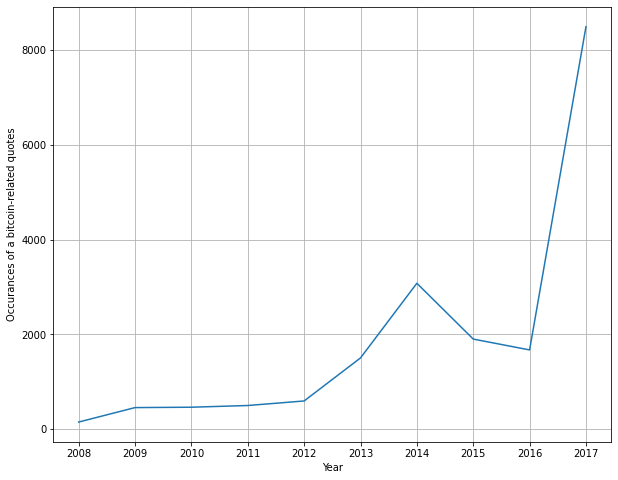

In [12]:
plt.figure(figsize=(10,8))
plt.plot(df.groupby('publish_year')['o'].count())
plt.xlabel("Year")
plt.ylabel("Occurances of a bitcoin-related quotes")
plt.grid()
plt.show()

> Seems like everything is okey, since the two main increases in popularity of bitcoin was indeed in `2014` and `2017`, according to the `Google trends`

> The most cited pearsons also seems reasonable

In [13]:
df.groupby(['s']).sum()['o'].sort_values(ascending=False).head(10)

s
jamie dimon             665
mark karpeles           626
thomas peterffy         589
craig wright            586
adrian lee              585
leah mcgrath goodman    504
charlie sheen           446
bobby lee               444
gavin andresen          437
tyler winklevoss        401
Name: o, dtype: int64

> Then we will reduce the number of occupations, since most of them are very simmilar. We will utilize `fuzzywuzzy` to find similar words. Then we will build a graph, where the vertices are the `occupations`, and adge between $o_i$ and $o_j$ exists if the similarity in terms of `fuzzywuzzy` metric is greater then a treshold.

In [14]:
import networkx
from networkx.algorithms.components.connected import connected_components
from fuzzywuzzy import fuzz
from collections import defaultdict, Counter

In [15]:
def to_graph(cliques):
    G = networkx.Graph()
    for cli in cliques:
        G.add_nodes_from(cli)
        G.add_edges_from(to_edges(cli))
    return G

def to_edges(l):
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current

In [16]:
occupations_dict = drop_similar(occupations_dict)

In [17]:
len(set(occupations_dict.values()))

599

In [18]:
ids = set(sum([e for e in df["occupation_ids"].values.sum() if e is not None], []))
for i in ids:
    if i not in occupations_dict:
        del occupations_dict[i]

In [19]:
names1 = (df.groupby("s").sum() > 10).reset_index()
names1 = names1.loc[names1["o"], "s"]
names1 = set(names1.values)
names2 = (df.groupby("s").count() > 3).reset_index()
names2 = names2.loc[names2["o"], "s"]
names2 = set(names2.values)

In [20]:
names = names2.intersection(names1)

In [21]:
df = df[df["s"].apply(lambda x: x in names)]

In [22]:
valuable = [
    "director", "scientist", "politician", "economist", 
    "manager", "software engineer", "businessperson", "entrepreneur", "programmer",
    "hacker", "podcaster", "banker", "investor", "trader", "inventor"
]

In [23]:
def select_occupation(x):
    output = []
    for elem in x:
        if elem is not None:
            output += list(occupations_dict[e] for e in elem)
    output = [o for o in output if o != "cryptozoologist"]
    result = [item for item, c in Counter(output).most_common()]
    if not output:
        return None
    else:
        if any(["crypto" in o for o in output]):
            for o in output:
                if "crypto" in o:
                    return o
            
        first = output[0].strip()
        if (first in ["sport", "writer", "actor", "community organizer", "lawyer", "journalist"]):
            if len(output) > 1:
                for n in valuable:
                    if (n in output):
                        return n
                return output[1]
            else:
                return output[0]
        else:
            return output[0]

In [24]:
df = df[df["birth"].apply(lambda x: len(x) < 2)]
df["occupation"] = df["occupation_ids"].apply(lambda x: select_occupation(x))

In [25]:
name2profession = {
    'adam bergman': 'financist', 
    'adam white': 'entrepreneur', 
    'adrian turner': 'director', 
    'amit bhardwaj': 'businessman',
    'andrew bailey': 'banker', 
    'ari juels': 'scientist', 
    'brad moore': 'ceo', 
    'brad stephens': 'politician',
    'charles evans': 'economist', 
    'charlie morris': 'investor', 
    'david mckay': 'ceo',
    'eamonn maguire': 'financist', 
    'eric schmidt': 'businessman', 
    'hussein sayed': 'investor', 
    'jamie burke': 'ceo', 
    'jason english': 'ceo',
    'joe lee': 'ceo', 
    "john o'rourke": 'scientist', 
    'jonathan levin': 'economist', 
    'jorge rodriguez': 'politician', 
    'joseph abraham': 'banker', 
    'ken moore': 'investor',
    'kevin hobbs': 'ceo', 
    'kurt baumgartner': 'ceo', 
    'mark mclaughlin': 'ceo',
    'matt gibson': 'scientist', 
    'neil wilson': 'ceo', 
    'nick stevens': 'financist', 
    'nuno correia': 'ceo', 
    'patrick njoroge': 'banker',
    'paul armstrong': 'scientist', 
    'paul donovan': 'economist', 
    'philip thomas': 'scientist', 
    'richard lumb': 'ceo',
    'ross norman': 'ceo', 
    'roy moore': 'politician', 
    'sanjay mehta': 'entrepreneur', 
    'saurabh agarwal': 'economist',
    'sean neville': 'ceo', 
    'sean sullivan': 'economist', 
    'sergei shvetsov': 'economist', 
    'simon johnson': 'economist',
    'todd cooper': 'ceo', 
    'vishal gupta': 'scientist',
    'alex daley': 'ceo',
    'andreas philipp': 'director',
    'andrew cox': 'scientist',
    'brad rose': 'manager',
    'david woo': 'scientist',
    'ian price': 'economist',
    'lisa kramer': 'financist',
    'mark williams': 'historian',
    'matt green': 'politician',
    'michael england': 'coo',
    'timothy roberts': 'historian',
    'wim raymaekers': 'manager',
    'anish shah': 'ceo',
    'austin craig': 'historian',
    'bobby lee': 'podcaster',
    'eric benz': 'ceo',
    'gore vidal': 'writer', # interesting
    'james canning': 'manager',
    'kumar gaurav': 'ceo',
    'mike mcglone': 'economist',
    'oliver wyman': 'director',
    'peter schiff': 'ceo',
    'shakil khan': 'entrepreneur',
}

df["occupation"] = df.apply(lambda x: name2profession[x["s"]] if x["s"] in name2profession else x["occupation"], axis=1)

In [26]:
df_grouped = df.groupby(['publish_year', 'occupation'], as_index=False).sum()
df_grouped_top = df_grouped.sort_values(['publish_year','o'], ascending=False).groupby(['publish_year'], as_index=False).head(20)

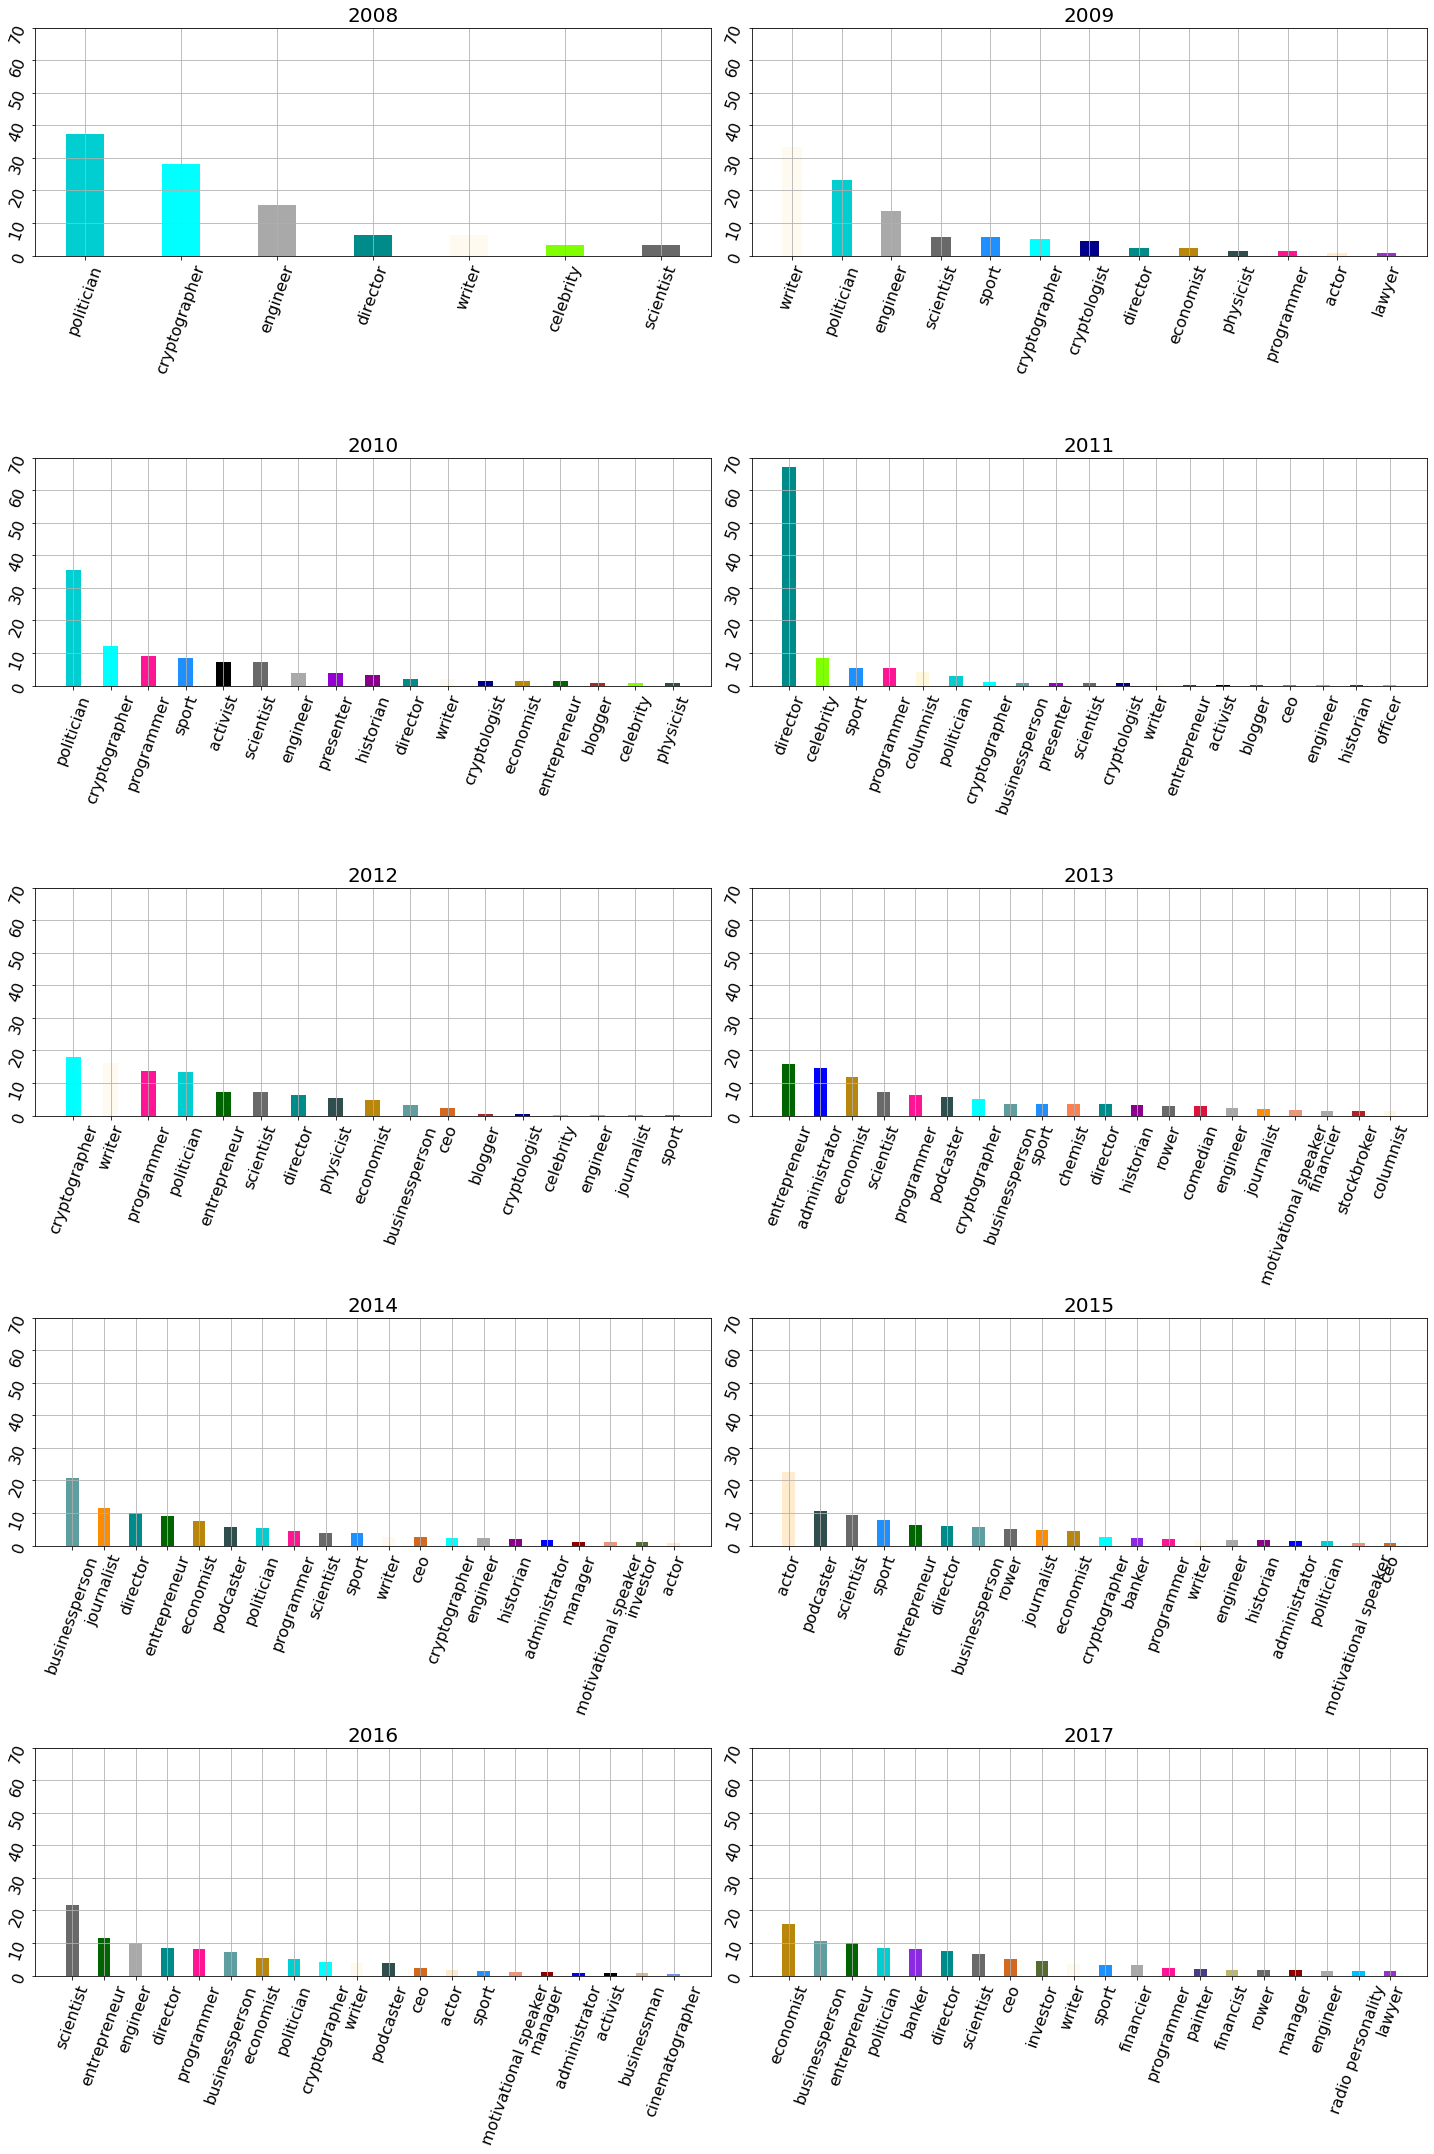

In [27]:
from matplotlib import colors as mcolors

group_colors = {}
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = list(colors.values())

unique_top_occupation_groups = [elem[0] for elem in df_grouped_top.groupby("occupation").sum().reset_index().values]
for i, group_number in enumerate(unique_top_occupation_groups):
    group_colors[group_number] = colors[i + 15]

years = np.unique(df_grouped_top.publish_year)

fig, axs = plt.subplots(5, 2, figsize=(20, 30))
for i, year in enumerate(years):
    year_df = df_grouped_top[df_grouped_top.publish_year == year]
    year_occupations = year_df.occupation.values
    
    for group_n, group_ in enumerate(year_occupations):
        temp_group = year_df[year_df.occupation == group_]
        axs[i // 2][i % 2].bar(
            group_,
            100 * temp_group.o.values[0] / year_df.o.sum(), 
            color=group_colors[group_],
            width=0.4,
            align='center'
        )
    axs[i // 2][i % 2].set_title(year, fontsize=20)
    axs[i // 2][i % 2].set_ylim([0, 70])
    axs[i // 2][i % 2].grid()
    axs[i // 2][i % 2].tick_params(axis='both', which='major', labelsize=16, rotation=70)
fig.tight_layout(pad=1.0)
plt.show()

> It seems like the distribution over is a little varied. As we can see, people with sport `occupation` speak up about `bitcoin` and `blockchain` rather more frequent, then other people. It is an interesting observation, since most of the quotes seems to be relevant to `bitcoin`, `blockchain`, and other buzz-words

In [28]:
df[df["occupation"] == "zoologist"].q.values

array([], dtype=object)